In [10]:
from imp import reload
import readpw; reload(readpw)
import helper; reload(helper)
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
rypw = readpw.Passwords('rockyou-withcount.txt.gz')
from zxcvbn import scoring, matching
import math

def entropy(w):
    matches = matching.omnimatch(w)
    g = scoring.most_guessable_match_sequence(w, matches)
    return math.log(g['guesses'], 2)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(print args)? (helper.py, line 119)

In [7]:
freq_level = {}
import numpy as np
f = -np.log2(rypw._freq_list[np.nonzero(rypw._freq_list)]/rypw.totalf())
fceil = np.ceil(f)

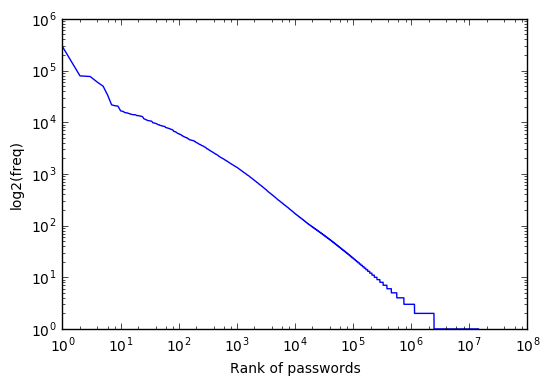

In [8]:
plt.loglog(range(1, rypw._freq_list.shape[0]+1), -np.sort(-rypw._freq_list))
plt.xlabel('Rank of passwords')
plt.ylabel('log2(freq)')

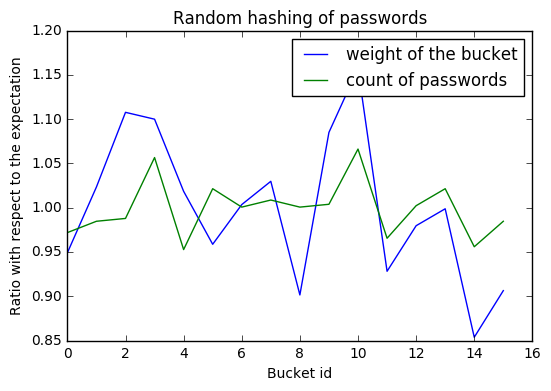

In [5]:
from hashlib import sha256
import os
sa = os.urandom(16)
def hash_(s):
    return sha256(bytes(s)+sa).hexdigest()[0]
bins = {hex(i)[-1:]: [0,0] for i in xrange(16)}

ignore_first = 10
total_pws = 10000 + ignore_first
for i, (_id,pw,f) in enumerate(rypw.iterpws(total_pws)):
    if i<ignore_first: continue
    bins[hash_(pw)][0] += f
    bins[hash_(pw)][1] += 1
    if i>total_pws: break
tot = float(sum(f for f,c in bins.values()))
expected = tot/16
cntmean = total_pws/16.0
x,y,z = zip(*sorted([(int(k, base=16),v/expected, c/cntmean) for k,(v,c) in bins.items()]))
plt.plot(x,y)
plt.plot(x,z)
plt.title("Random hashing of passwords")
plt.xlabel("Bucket id")
plt.ylabel("Ratio with respect to the expectation")
plt.legend(['weight of the bucket', 'count of passwords',])

# Point to note, that on many many runs the maximum and minimum bucket weight stays within,
# 15% daviation from the expected value.

# FRS2 (Fuller et al, layered construction)


In [5]:
brange = range(0, 10001, 100)
qrange = range(1, 100, 10) + range(100, 10000, 100) + range(10000, 100000, 1000) + range(100000, 1000001, 10000)
sketchrange = range(0, 11, 1)
n = qrange[-1] * 2**sketchrange[-1]
ordered_fs = np.sort(rypw._freq_list)[::-1][:n]

In [ ]:
def compute_black_list_succ(b, s):
    n_sketches = 2**s
    nfarr = np.concatenate([ordered_fs[:b]/n_sketches for _ in range(n_sketches)])
    nfarr = np.concatenate((nfarr, ordered_fs[b:qrange[-1]*n_sketches]))
    nfarr = np.sort(nfarr)[::-1]
    return np.array([nfarr[:q*n_sketches].sum()/rypw.totalf() for q in qrange])

from joblib import Parallel, delayed
p = Parallel(n_jobs=4)
func = delayed(compute_black_list_succ)
succ_rates = np.zeros(shape=(len(brange), len(sketchrange), len(qrange)))
l = []
for bi, b in enumerate(brange):
    for sj, s in enumerate(sketchrange):
        l.append(func(b, s))
res = p(l)
for bi, b in enumerate(brange):
    print b
    for sj, s in enumerate(sketchrange):
        succ_rates[bi, sj] = np.array(res[bi*len(sketchrange) + sj])

In [30]:
b, s = 10, 2
n_sketches = 2**s
q = 100
nfarr = np.concatenate([ordered_fs[:b]/n_sketches for _ in range(n_sketches)])
nfarr = np.concatenate((nfarr, ordered_fs[b:qrange[-1]*n_sketches]))
nfarr = np.sort(nfarr)[::-1]
nfarr[:q*n_sketches].sum()/rypw.totalf()

0.077561007873909418

## Increase in q-success rate for different sizes of sketches and q values. 

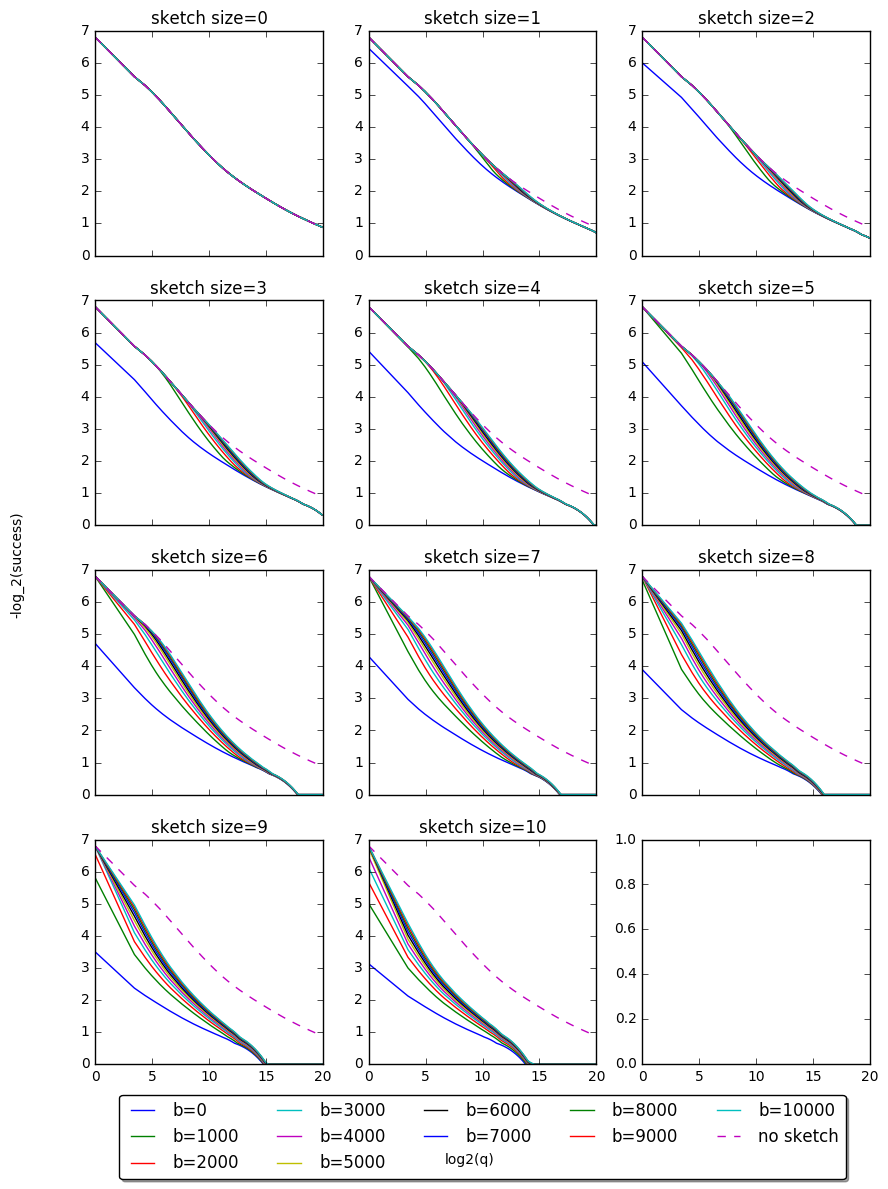

In [124]:
from matplotlib import pyplot as plt
# b, s
r = 4
c = 3
w = 10
f, ax = plt.subplots(r, c, sharex=True)
f.set_size_inches(w, w*r/float(c))
i,j = 0, 8

for j in range(len(sketchrange)):
    for i in range(0, len(brange), 10):
        ax[j/c, j%c].plot(np.log2(qrange), -np.log2(succ_rates[i,j]), label='b={}'.format(brange[i]))
        ax[j/c, j%c].set_title('sketch size={}'.format(sketchrange[j]))
    ax[j/c, j%c].plot(np.log2(qrange), -np.log2(succ_rates[0,0]), '--', label='no sketch')

f.text(0.5, 0.05, 'log2(q)', ha='center')
f.text(0.04, 0.5, '-log_2(success)', va='center', rotation='vertical')
ax[-1, -2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('attack_success.png')

## Computig security loss for our layered construction
Replace each password in layer i with $2^{(\lambda - i)}$ copies each with probability $p_W(w)/2^{(\lambda -i)}$. 

Parameter assumption
* $\delta = 2^{-2}$
* $H^{fuzz} = \mu - 2$

(14334291,)
24.8082410914 6.80824109145
Layer=6.80824109145, num_copies=262144.0, layer_size=1, total=262144.0
Layer=7.80824109145, num_copies=131072.0, layer_size=2, total=262144.0
Layer=8.80824109145, num_copies=65536.0, layer_size=2, total=131072.0
Layer=9.80824109145, num_copies=32768.0, layer_size=4, total=131072.0
Layer=10.8082410914, num_copies=16384.0, layer_size=34, total=557056.0
Layer=11.8082410914, num_copies=8192.0, layer_size=116, total=950272.0
Layer=12.8082410914, num_copies=4096.0, layer_size=316, total=1294336.0
Layer=13.8082410914, num_copies=2048.0, layer_size=753, total=1542144.0
Layer=14.8082410914, num_copies=1024.0, layer_size=1524, total=1560576.0
Layer=15.8082410914, num_copies=512.0, layer_size=3018, total=1545216.0
Layer=16.8082410914, num_copies=256.0, layer_size=6643, total=1700608.0
Layer=17.8082410914, num_copies=128.0, layer_size=16185, total=2071680.0
Layer=18.8082410914, num_copies=64.0, layer_size=34582, total=2213248.0
Layer=19.8082410914, num_copie

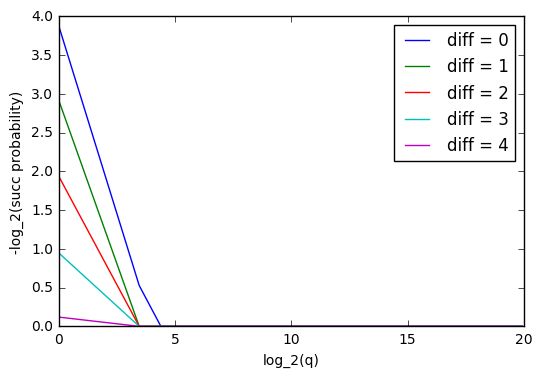

In [72]:
from matplotlib import pyplot as plt
import math

def compute_layered_construction_succ():
    freqs = rypw.values()
    print freqs.shape
    lmbda = -np.log2(2/rypw.totalf())
    mu = -np.log2(freqs.max()/rypw.totalf())
    lmbda = mu + int(lmbda - mu)+1
    print lmbda, mu
    i = mu
    L = [[] for _ in range(int(lmbda-mu+2))]
    while i<lmbda:
        e, s = rypw.totalf()/2**i, rypw.totalf()/2**(i+1)
        t = freqs[(s<freqs) & (freqs<=e)]
        factor = 2**(lmbda-i)
        print "Layer={}, num_copies={}, layer_size={}, total={}".format(i, factor,t.shape[0], t.shape[0]*factor)
        L[int(i-mu)] = np.repeat(t, factor)/factor
        i += 1
    L[int(i-mu)] = freqs[(rypw.totalf()/2**i)>freqs]
    large_arr = np.concatenate(L)
    print "Total size after duplication: {:,}".format(large_arr.shape[0])
    large_arr.sort()
    large_arr = large_arr[::-1]
    b = int(2**(lmbda - mu + 3))   # Making an wild assumption about H^fuzz(W) - log(1/\delta) - 1 = mu
    ret = np.zeros((5, len(qrange)))
    for i, q in enumerate(qrange):
        for j in range(5):
            bprime = b*(2**j)
            if i>0:
                ret[j][i] = (large_arr[qrange[i-1]*bprime:q*bprime].sum() + ret[j][i-1])
            else:
                ret[j][i] = (large_arr[:q*bprime].sum())
                
    print "b={}".format(b)
    return large_arr, np.array(ret)/rypw.totalf()

large_arr, succ = compute_layered_construction_succ()
for i, s in enumerate(succ):
    plt.plot(np.log2(qrange), -np.log2(s), label="diff = {}".format(i))
plt.xlabel('log_2(q)')
plt.ylabel('-log_2(succ probability)')
plt.legend()
# # b, s
# r = 4
# c = 3
# w = 10
# f, ax = plt.subplots(r, c, sharex=True)
# f.set_size_inches(w, w*r/float(c))
# i,j = 0, 8

# for j in range(len(sketchrange)):
#     for i in range(len(brange)):
#         ax[j/c, j%c].plot(np.log2(qrange), -np.log2(succ_rates[i,j]), label='b={}'.format(brange[i]))
#         ax[j/c, j%c].set_title('sketch size={}'.format(sketchrange[j]))
#     ax[j/c, j%c].plot(np.log2(qrange), -np.log2(succ_rates[0,0]), '--', label='no sketch')

# f.text(0.5, 0.05, 'log2(q)', ha='center')
# f.text(0.04, 0.5, '-log_2(success)', va='center', rotation='vertical')
# ax[-1, -2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#           fancybox=True, shadow=True, ncol=5)

16.38532317617587